In [45]:
import pandas as pd
import numpy as np
import os
import re
from tqdm.auto import tqdm 
tqdm.pandas()

import matplotlib.pyplot as plt
import seaborn as sns
from git import repo

sns.set_style("whitegrid")

input_file = "/home/tim/cluster/openmp-usage-analysis/result.csv"
input_file_pragmas = "/home/tim/cluster/openmp-usage-analysis/pragma_result.csv"
input_file_metadata = "/home/tim/scratch/openmp-usage-analysis-binaries/result.csv"
input_file_date = "/home/tim/scratch/openmp-usage-analysis-binaries/fixed_commit_dates.csv"

plot_path = "/home/tim/paper/openmp-analysis-paper/media"
df = pd.read_csv(input_file, index_col=0)
df_pragmas = pd.read_csv(input_file_pragmas, index_col=0)
df_repo_metadata = pd.read_csv(input_file_metadata, index_col=0)
df_date = pd.read_csv(input_file_date, index_col=0)

In [46]:
#pre-processing
df_repo_metadata["Code"] = df_repo_metadata["Code"].str.replace("/", "--")

In [47]:
OVERHEAD_THRESHOLD = 100

In [48]:
df["large_overhead"] = df["instructions_weighted"] < OVERHEAD_THRESHOLD
df["small_overhead"] = df["instructions_weighted"] >= OVERHEAD_THRESHOLD

In [49]:
len(df["Code"].unique())

537

In [50]:
df["large_overhead"].sum() / (df["large_overhead"].sum() +df["small_overhead"].sum())  

0.4250075142771265

In [51]:
#df["instructions_weighted"].quantile(0.90)
df["instructions_flat"].quantile(0.9)

1404.0

In [52]:
df["large_overhead_flat"] = df["instructions_flat"] < OVERHEAD_THRESHOLD
df["large_overhead_flat"].sum() / (df["large_overhead"].sum() +df["small_overhead"].sum())  

0.47956116621581

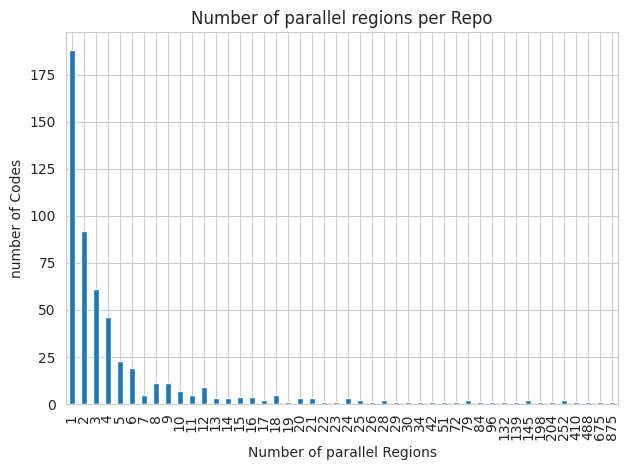

In [53]:
# Number of parallel regions per Repo
ax = df.groupby("Code").size().value_counts().sort_index().plot.bar()
ax.set_xlabel("Number of parallel Regions")
ax.set_ylabel("number of Codes")
ax.set_title("Number of parallel regions per Repo")
plt.savefig(os.path.join(plot_path, "num_regions.pdf"))
plt.tight_layout()
plt.show()


In [54]:
df["default_tripcount_loops"].sum()

119232

In [55]:
df["known_tripcount_loops"].sum()

2080

In [56]:
df["thread_dependant_trip_count_loops"].sum()

1417

Fragen:
Wie viele user beachten die aspekte um gute openmp usage zu haben


Analyse per project

Verhältnis overhead/parallel region per project
overhead mit 100 instructions annehmen
codegröße insgesamt
Wie viele regions per project, welcher typ

welche konstrukte

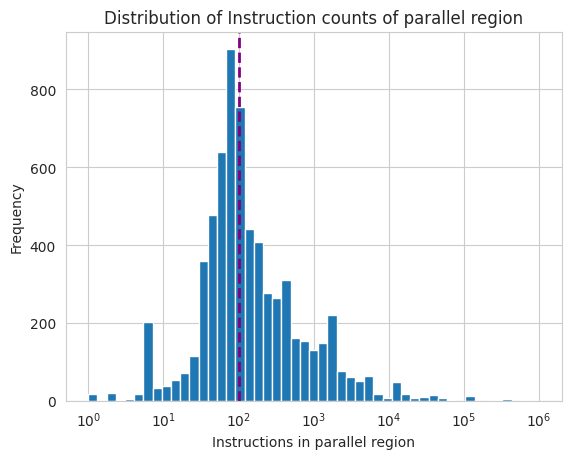

In [57]:
ax = df["instructions_flat"].plot.hist(bins=np.logspace(start=0, stop=6))
ax.set_xscale("log")
ax.set_xlabel("Instructions in parallel region")
ax.set_title("Distribution of Instruction counts of parallel region")
ax.axvline(x=100,color='purple', ls='--', lw=2)
plt.savefig(os.path.join(plot_path, "flat_instructions_distribution.pdf"))

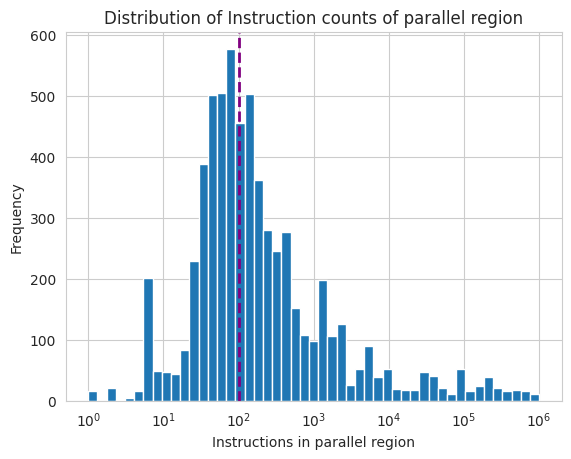

In [58]:
# mit anderem default tripcount 10k oder so
ax = df["instructions_weighted"].plot.hist(bins=np.logspace(start=0, stop=6, num=50))
ax.set_xscale("log")
ax.set_xlabel("Instructions in parallel region")
ax.set_title("Distribution of Instruction counts of parallel region")
ax.axvline(x=100,color='purple', ls='--', lw=2)
plt.savefig(os.path.join(plot_path, "weighted_instructions_distribution.pdf"))

In [59]:
df_overhead_rating = df.groupby("Code")[["large_overhead", "small_overhead"]].sum()
df_overhead_rating['percentage'] = df_overhead_rating['large_overhead'] / (
        df_overhead_rating['large_overhead'] + df_overhead_rating['small_overhead'])

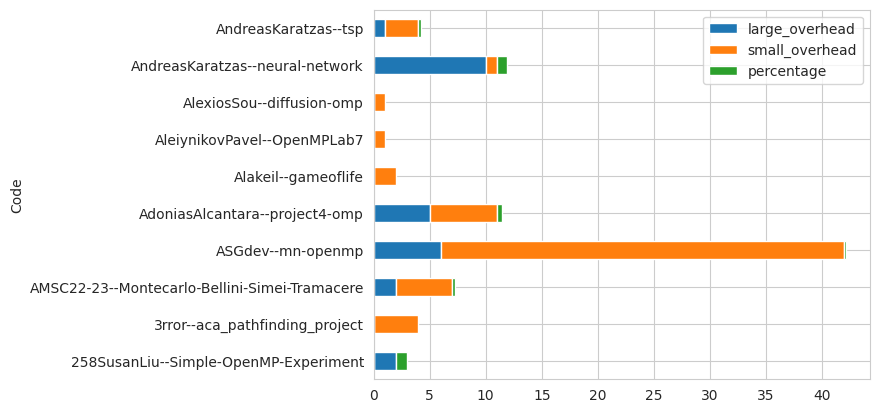

In [60]:
# plot an excerpt
ax = df_overhead_rating.iloc[0:10].plot.barh(stacked=True)

In [61]:
# Repos with at least one example of large overhead region
(df_overhead_rating["large_overhead"] > 1).sum()

158

Text(0.5, 1.0, 'Fraction of high overhead parallel regions per project')

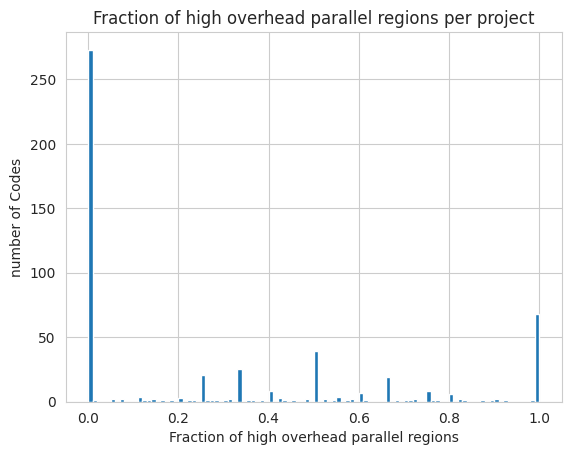

In [62]:
ax = df_overhead_rating['percentage'].plot.hist(bins=100)
ax.set_xlabel("Fraction of high overhead parallel regions")
ax.set_ylabel("number of Codes")
ax.set_title("Fraction of high overhead parallel regions per project")

#plt.savefig(os.path.join(plot_path,"plot.pdf"))

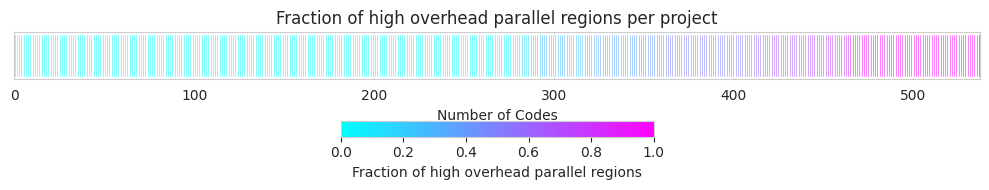

In [63]:
fig, ax = plt.subplots(figsize=(10, 2))

data = df_overhead_rating['percentage'].sort_values()

# Normalize the percentage values to use as colors
# Normalize the percentage values to use as colors
norm = plt.Normalize(data.min(), data.max())
sm = plt.cm.ScalarMappable(cmap="cool", norm=norm)
colors = sm.to_rgba(data)

# Plot the horizontal bar segments
start = 0
for i, percentage in enumerate(data):
    ax.barh(0, 1, left=start, color=colors[i]
            #, edgecolor='black'
            )
    start += 1

# Set the labels and title
ax.set_xlabel("Number of Codes")
ax.set_yticks([])  # Hide y-axis ticks
ax.set_xlim([0, len(data)])
ax.set_title("Fraction of high overhead parallel regions per project")

# Add a legend
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.4)
cbar.set_label('Fraction of high overhead parallel regions')
fig.tight_layout()
plt.savefig(os.path.join(plot_path, "fraction_per_project_old.pdf"))
plt.show()


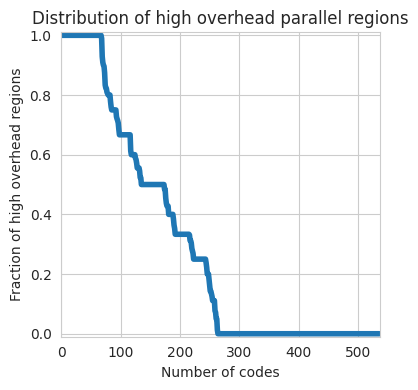

In [64]:
fig, ax = plt.subplots(figsize=(4, 4))

data = df_overhead_rating['percentage'].sort_values(ascending=False)

ax.plot(range(len(data)), data, linewidth=4)

# Set the labels and title
ax.set_xlabel("Number of codes")
ax.set_ylabel("Fraction of high-overhead regions")
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, len(data)])
ax.set_title("Distribution of high-overhead parallel regions")

fig.tight_layout()
plt.savefig(os.path.join(plot_path, "fraction_high_overhead_per_project.pdf"), bbox_inches='tight')
plt.show()

In [65]:
#df_loops = df.groupby("Code")[["default_tripcount_loops","known_tripcount_loops","thread_dependant_trip_count_loops"]].sum()

In [66]:
df["loop_sum"] = df[["default_tripcount_loops", "known_tripcount_loops", "thread_dependant_trip_count_loops"]].sum(
    axis=1)

In [67]:
df

,name,addr,instructions_flat,instructions_weighted,default_tripcount_loops,known_tripcount_loops,thread_dependant_trip_count_loops,recursions,TOTAL_FILE_INSTR_COUNT,DEFAULT_TRIPCOUNT_GUESS,Code,File,large_overhead,small_overhead,large_overhead_flat,loop_sum
0,_Z14calcPiParallelv._omp_fn.0,4201074,73,115.500000,1,0,1,0,2239,3,DesmanLead--learn-openmp,mplearn,False,True,True,2
1,_Z17matrixSumParallelv._omp_fn.0,4202097,154,135.484375,2,3,0,0,2239,3,DesmanLead--learn-openmp,mplearn,False,True,False,5
2,_Z15simpsonParallelPFddEdd._omp_fn.0,4203378,85,64.312500,3,0,0,0,2239,3,DesmanLead--learn-openmp,mplearn,True,False,True,3
3,_Z19parallelSolveLinearPPdS_l._omp_fn.0,4206736,244,158.671875,3,0,0,0,2239,3,DesmanLead--learn-openmp,mplearn,False,True,False,3
4,_Z19parallelSolveLinearPPdS_l._omp_fn.1,4207793,111,83.718750,3,0,0,0,2239,3,DesmanLead--learn-openmp,mplearn,True,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,_Z9partitionmiPmS_._omp_fn.3,4200032,35,55.000000,1,0,0,0,1690,3,chenghz4--openmp_224,quicksort,True,False,True,1
3,_Z9partitionmiPmS_._omp_fn.2,4200144,59,100.500000,1,0,0,0,1690,3,chenghz4--openmp_224,quicksort,False,True,True,1
4,_Z9partitionmiPmS_._omp_fn.1,4200336,45,65.000000,1,0,0,0,1690,3,chenghz4--openmp_224,quicksort,True,False,True,1
5,_Z9quickSortiPmS_._omp_fn.4,4202544,3094,13565.250000,36,0,0,1,1690,3,chenghz4--openmp_224,quicksort,False,True,False,36


loop_sum
1        1659
2        1513
0        1040
3         773
4         355
         ... 
203         1
10017       1
5014        1
692         1
60          1
Name: count, Length: 92, dtype: int64

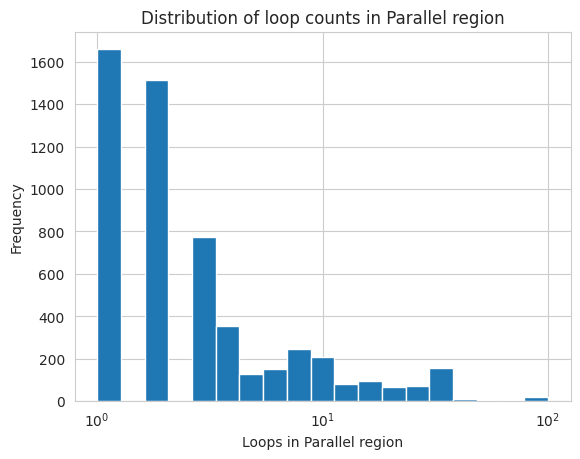

In [68]:
ax = df["loop_sum"].plot.hist(bins=np.logspace(start=0, stop=2, num=20))
ax.set_xscale("log")
ax.set_xlabel("Loops in Parallel region")
ax.set_title("Distribution of loop counts in Parallel region")
#plt.savefig(os.path.join(plot_path, "loops_distribution.pdf"))
df["loop_sum"].value_counts()

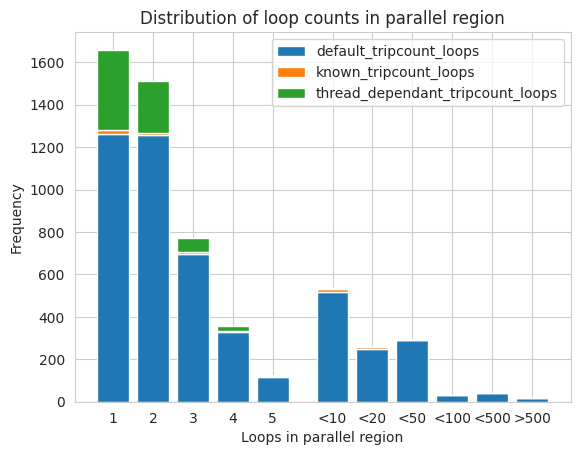

[379.0,
 244.5,
 67.33333333333346,
 23.25,
 6.600000000000003,
 8.255952380952383,
 4.177728540809035,
 1.3908682591481887,
 0.19329702555509007,
 0.21348338987334753,
 0.0038260387544586908]

In [69]:
# manual sorting into the bins
bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 500]
plot_pos= [1, 2, 3, 4, 5, 6 + 0.5, 7 + 0.5, 8 + 0.5, 9 + 0.5, 10 + 0.5, 11 + 0.5]

default = [0 for _ in range(len(bins) + 1)]
known = [0 for _ in range(len(bins) + 1)]
thread = [0 for _ in range(len(bins) + 1)]

for idx, row in df.iterrows():
    if row['loop_sum'] > 0:
        b_index = np.searchsorted(bins, row["loop_sum"])
        default[b_index] += row["default_tripcount_loops"] / row["loop_sum"]
        known[b_index] += row["known_tripcount_loops"] / row["loop_sum"]
        thread[b_index] += row["thread_dependant_trip_count_loops"] / row["loop_sum"]

fig, ax = plt.subplots()
ax.bar(
    plot_pos,
    default,
    label="default_tripcount_loops",
    align='edge',
)
ax.bar(
    plot_pos,
    known,
    bottom=default,
    label="known_tripcount_loops",
    align='edge',
)
ax.bar(
    plot_pos,
    thread,
    bottom=np.add(default, known),
    label="thread_dependant_tripcount_loops",
    align='edge',
)

ax.set_xlabel("Loops in parallel region")
ax.set_ylabel("Frequency")
# bar coloring according to percentages of loops
ax.set_title("Distribution of loop counts in parallel region")
ax.set_xticks(ticks=np.array(plot_pos) + 0.4,
              labels=[1, 2, 3, 4, 5, "<10", "<20", "<50", "<100", "<500", ">500"])
ax.legend()

plt.savefig(os.path.join(plot_path, "loops_distribution.pdf"))
plt.show()

thread

In [70]:
# per file statistics
df_parallel_portion = df.groupby(["Code", "File"]).agg(
    instructions_flat=pd.NamedAgg(column="instructions_flat", aggfunc="sum"),
    TOTAL_FILE_INSTR_COUNT=pd.NamedAgg(column="TOTAL_FILE_INSTR_COUNT", aggfunc="max")
).reset_index()
# per project
df_parallel_portion = df_parallel_portion.groupby("Code")[["instructions_flat", "TOTAL_FILE_INSTR_COUNT"]].sum()
df_parallel_portion["percent_parallel"] = df_parallel_portion["instructions_flat"] / (
        df_parallel_portion["instructions_flat"] + df_parallel_portion["TOTAL_FILE_INSTR_COUNT"])
df_parallel_portion

,instructions_flat,TOTAL_FILE_INSTR_COUNT,percent_parallel
Code,,,
258SusanLiu--Simple-OpenMP-Experiment,98,372,0.208511
3rror--aca_pathfinding_project,14754,10894,0.575250
AMSC22-23--Montecarlo-Bellini-Simei-Tramacere,19051,41705,0.313566
ASGdev--mn-openmp,7244,28288,0.203873
AdoniasAlcantara--project4-omp,935,1511,0.382257
...,...,...,...
zhishang72--MatrixMulMatrix,306,664,0.315464
zjzoloo--mandelbrot-with-openMP,119,19914,0.005940
zosiakropka--trigrams-openmp,505,3760,0.118406


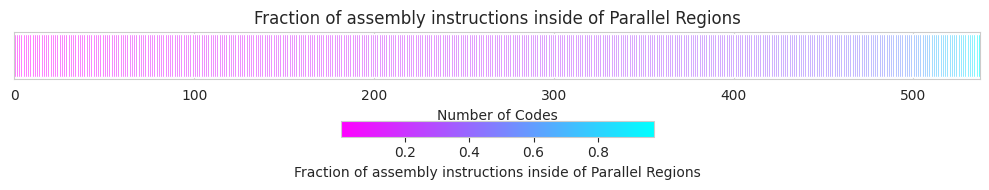

In [71]:
fig, ax = plt.subplots(figsize=(10, 2))

data = df_parallel_portion['percent_parallel'].sort_values()

# Normalize the percentage values to use as colors
# Normalize the percentage values to use as colors
norm = plt.Normalize(data.min(), data.max())
sm = plt.cm.ScalarMappable(cmap=plt.colormaps.get_cmap("cool").reversed(), norm=norm)
colors = sm.to_rgba(data)

# Plot the horizontal bar segments
start = 0
for i, percentage in enumerate(data):
    ax.barh(0, 1, left=start, color=colors[i]
            #, edgecolor='black'
            )
    start += 1

# Set the labels and title
ax.set_xlabel("Number of Codes")
ax.set_yticks([])  # Hide y-axis ticks
ax.set_xlim([0, len(data)])
ax.set_title("Fraction of assembly instructions inside of Parallel Regions")

# Add a legend
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.4)
cbar.set_label('Fraction of assembly instructions inside of Parallel Regions')
fig.tight_layout()
plt.savefig(os.path.join(plot_path, "fraction_of_parallel_region_old.pdf"))
plt.show()

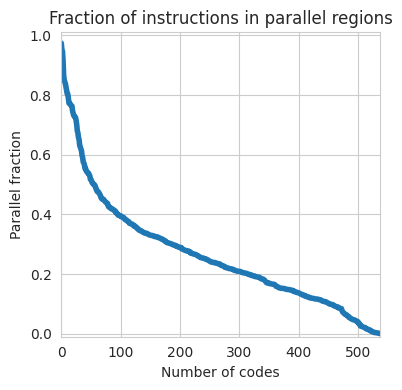

In [72]:
fig, ax = plt.subplots(figsize=(4, 4))

data = df_parallel_portion['percent_parallel'].sort_values(ascending=False)

ax.plot(range(len(data)), data, linewidth=4)

# Set the labels and title
ax.set_xlabel("Number of codes")
ax.set_ylabel("Parallel fraction")
ax.set_ylim([-0.01, 1.01])
ax.set_xlim([0, len(data)])
ax.set_title("Fraction of instructions in parallel regions")

fig.tight_layout()
plt.savefig(os.path.join(plot_path, "fraction_of_parallel_region.pdf"), bbox_inches='tight')
plt.show()

In [73]:
#pd.to_datetime(df_repo_metadata["PushDate"])
#for schedule(dynamic, 10) nowait

In [74]:
def get_closing_brace(s, start_pos):
    """
    Returns the position of the corresponding closing brace given a string and the position of an opening brace.

    Parameters:
    s (str): The string to search for the closing brace.
    start_pos (int): The position of the opening brace.

    Returns:
    int: The position of the closing brace, or -1 if not found.
    """
    # get the opening brace character
    open_brace = s[start_pos]

    # determine the closing brace character
    if open_brace == '(':
        close_brace = ')'
    elif open_brace == '[':
        close_brace = ']'
    elif open_brace == '{':
        close_brace = '}'
    else:
        # not a valid opening brace character
        return -1

    # search for the closing brace
    count = 1
    pos = start_pos + 1
    while pos < len(s) and count > 0:
        if s[pos] == open_brace:
            count += 1
        elif s[pos] == close_brace:
            count -= 1
        pos += 1

    # return the position of the closing brace
    if count == 0:
        return pos - 1
    else:
        return -1


def tokenize_pragma(pragma):
    # removes extra specification in the braces
    without_braces = pragma
    while '(' in without_braces:
        index = without_braces.find('(')
        closing = get_closing_brace(without_braces, index)
        without_braces = (without_braces[:index] + without_braces[closing + 1:])
    return without_braces.strip().split(' ')


df_pragmas["openmp_pragma_tokenized"] = df_pragmas["openmp_pragma_used"].apply(tokenize_pragma)
all_clauses = set([clause for clauses in df_pragmas["openmp_pragma_tokenized"] for clause in clauses])
if '' in all_clauses:
    all_clauses.remove('')

for c in all_clauses:
    df_pragmas[c] = df_pragmas['openmp_pragma_tokenized'].apply(lambda x: c in x)
df_pragmas["parallel_for"] = df_pragmas["parallel"] & df_pragmas["for"]
# Set 'parallel' and 'for' columns to False where 'parallel_for' is True
df_pragmas.loc[df_pragmas['parallel_for'], ['parallel', 'for']] = False
df_pragmas = df_pragmas.copy()


/tmp/ipykernel_26505/2504782925.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pragmas[c] = df_pragmas['openmp_pragma_tokenized'].apply(lambda x: c in x)
/tmp/ipykernel_26505/2504782925.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_pragmas[c] = df_pragmas['openmp_pragma_tokenized'].apply(lambda x: c in x)
/tmp/ipykernel_26505/2504782925.py:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all c

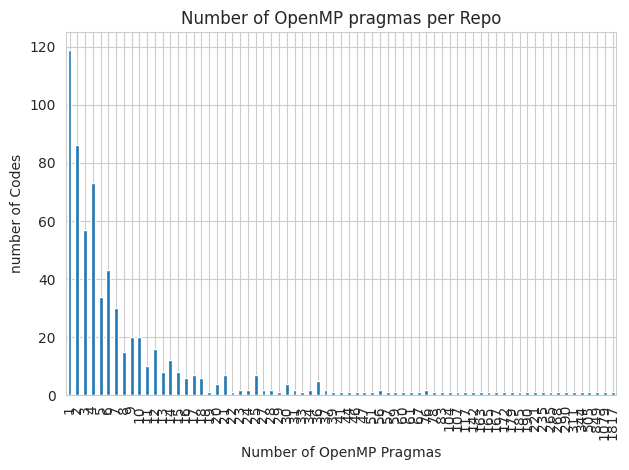

1       119
2        86
4        73
3        57
6        43
       ... 
268       1
117       1
344       1
1817      1
1079      1
Name: count, Length: 71, dtype: int64

In [75]:
#df_pragmas.groupby(["Code"]).size().sort_values(ascending=False)
ax = df_pragmas.groupby("Code").size().value_counts().sort_index().plot.bar()
ax.set_xlabel("Number of OpenMP Pragmas")
ax.set_ylabel("number of Codes")
ax.set_title("Number of OpenMP pragmas per Repo")
plt.savefig(os.path.join(plot_path, "num_pragmas_old.pdf"))
plt.tight_layout()
plt.show()
df_pragmas.groupby("Code").size().value_counts()

In [76]:
#df_pragmas.groupby(["Code"]).sum()


In [77]:
#ax = df_pragmas.groupby(["Code"])["for"].sum().value_counts().sort_index().plot.bar()
#ax.set_xlabel("Number of For Pragmas")
#ax.set_ylabel("number of Codes")
#ax.set_title("Number of omp for pragmas per Repo")
#plt.savefig(os.path.join(plot_path, "num_for_pragma.pdf"))
#plt.tight_layout()
#plt.show()

In [78]:
#ax = df_pragmas.groupby(["Code"])["parallel"].sum().value_counts().sort_index().plot.bar()
#ax.set_xlabel("Number of parallel Pragmas")
#ax.set_ylabel("number of Codes")
#ax.set_title("Number of omp parallel pragmas per Repo")
#plt.savefig(os.path.join(plot_path, "num_parallel_pragma.pdf"))
#plt.tight_layout()
#plt.show()
#df_pragmas.groupby(["Code"])["parallel"].sum().value_counts()

In [79]:
#ax = df_pragmas.groupby(["Code"])["task"].sum().value_counts().sort_index().plot.bar()
#ax.set_xlabel("Number of task Pragmas")
#ax.set_ylabel("number of Codes")
#ax.set_title("Number of omp task pragmas per Repo")
#plt.savefig(os.path.join(plot_path, "num_task_pragma.pdf"))
#plt.tight_layout()
#plt.show()

In [80]:
pivot_table = pd.pivot_table(df_pragmas, columns="Code", values=all_clauses.union(["parallel_for"]), aggfunc="sum")
# parallel for is both parallel and for
pivot_table.loc["parallel"] = pivot_table.loc["parallel"] - pivot_table.loc["parallel_for"]
pivot_table.loc["for"] = pivot_table.loc["for"] - pivot_table.loc["parallel_for"]

In [81]:
pivot_table.sum(axis=1).sort_values(ascending=False)

parallel_for            2953
private                 1290
task                    1244
schedule                1097
shared                   918
                        ... 
mask                       1
<ompts:check>private       1
POMP2_DLIST_00002          1
parallel                -569
for                    -1219
Length: 146, dtype: int64

In [82]:
#to_view = ["parallel","for","parallel_for","task","section","critical","single","simd","atomic","barrier"]
to_view = ["parallel", "for", "parallel_for", "task", "section", "critical", "single", "atomic", "barrier"]
not_to_view = ["Code", "src_location", "src_location_line_number", "call", "openmp_pragma_used",
               "openmp_pragma_tokenized"]
relevant_cols = [c for c in df_pragmas.columns if c not in not_to_view]

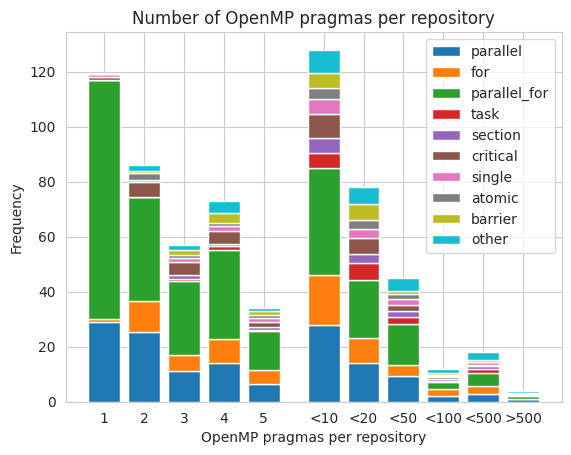

[87.0,
 38.0,
 27.000000000000004,
 32.25,
 13.999999999999998,
 39.07936507936508,
 21.15172861194533,
 14.80744831023452,
 2.4629880096593033,
 4.512930209122559,
 0.8237320151580497]

In [83]:
grouping = df_pragmas.groupby(["Code"]).sum()
# manual sorting into the bins
bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 500]

cat_data = {key: [0 for _ in range(len(bins) + 1)] for key in to_view + ["other"]}

for idx, row in grouping.iterrows():
    sum_pragmas = df_pragmas.groupby("Code").size()[row.name]
    if sum_pragmas > 0:
        b_index = np.searchsorted(bins, sum_pragmas)
        sum_shown = 0
        for cat in to_view:
            cat_data[cat][b_index] += row[cat] / sum_pragmas
            sum_shown += row[cat]
        cat_data["other"][b_index] += (sum_pragmas - sum_shown) / sum_pragmas

fig, ax = plt.subplots()
bot = np.zeros(len(bins) + 1)
for cat in to_view + ["other"]:
    ax.bar(
        [1, 2, 3, 4, 5, 6 + 0.5, 7 + 0.5, 8 + 0.5, 9 + 0.5, 10 + 0.5, 11 + 0.5],
        cat_data[cat],
        label=cat,
        #width=10,
        align='edge',
        bottom=bot
    )
    bot += cat_data[cat]

#ax.set_xscale("log")
ax.set_xlabel("OpenMP pragmas per repository")
ax.set_xticks(ticks=np.array([1, 2, 3, 4, 5, 6 + 0.5, 7 + 0.5, 8 + 0.5, 9 + 0.5, 10 + 0.5, 11 + 0.5]) + 0.4,
              labels=[1, 2, 3, 4, 5, "<10", "<20", "<50", "<100", "<500", ">500"])
ax.set_ylabel("Frequency")
# bar coloring according to percentages of loops
ax.set_title("Number of OpenMP pragmas per repository")
ax.legend()

plt.savefig(os.path.join(plot_path, "num_pragmas.pdf"))
plt.show()

cat_data["parallel_for"]


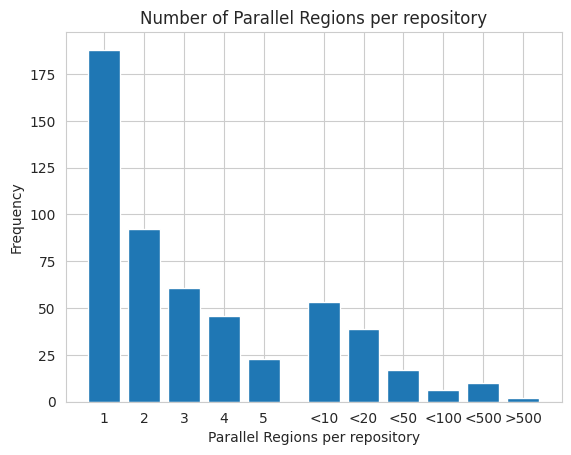

188

In [84]:
grouping = df.groupby("Code").size()
# manual sorting into the bins
bins = [1, 2, 3, 4, 5, 10, 20, 50, 100, 500]

data = [0 for _ in range(len(bins) + 1)]

for elem in grouping:
    sum_regions = elem

    if sum_regions > 0:
        b_index = np.searchsorted(bins, sum_regions)
        data[b_index] += 1

fig, ax = plt.subplots()

ax.bar(
    [1, 2, 3, 4, 5, 6 + 0.5, 7 + 0.5, 8 + 0.5, 9 + 0.5, 10 + 0.5, 11 + 0.5],
    data,
    #label=cat,
    #width=10,
    align='edge',
    # bottom=bot
)

#ax.set_xscale("log")
ax.set_xlabel("parallel regions per repository")
ax.set_xticks(ticks=np.array([1, 2, 3, 4, 5, 6 + 0.5, 7 + 0.5, 8 + 0.5, 9 + 0.5, 10 + 0.5, 11 + 0.5]) + 0.4,
              labels=[1, 2, 3, 4, 5, "<10", "<20", "<50", "<100", "<500", ">500"])
ax.set_ylabel("Frequency")
# bar coloring according to percentages of loops
ax.set_title("Number of parallel regions per repository")
#ax.legend()

plt.savefig(os.path.join(plot_path, "num_regions.pdf"))
plt.show()

data[0]

In [85]:
df_stars_with_rating = pd.concat([df_overhead_rating, df_repo_metadata.set_index("Code")], axis=1)

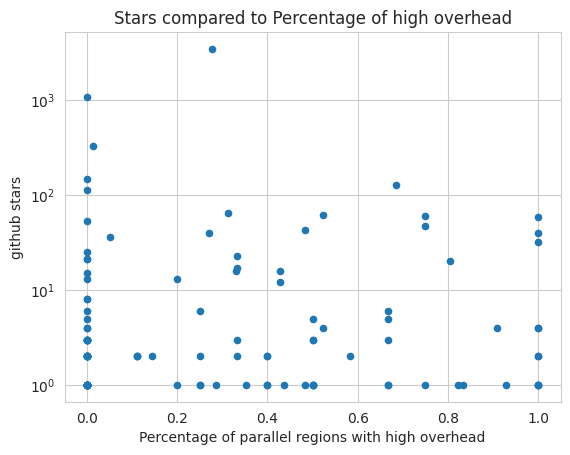

In [86]:
ax = df_stars_with_rating.plot.scatter("percentage","Stars")
ax.set_title("Stars compared to percentage of high overhead")
#ax.set_ylim([9,400])
ax.set_yscale("log")
ax.set_ylabel("GitHub stars")
ax.set_xlabel("Percentage of parallel regions with high overhead")
plt.savefig(os.path.join(plot_path, "stars_overhead.pdf"))

In [87]:
(df_stars_with_rating["Stars"]>1000).sum()

4

In [89]:
#from github import Github
#from github import Auth
## unauthorized access possible but it has limit of 60 requests per second
#auth = Auth.Token("")
#g = Github(auth=auth)

##populate the missing push dates
#push_date_df = pd.read_csv("/home/tim/scratch/openmp-usage-analysis-binaries/fixed_commit_dates.csv",index_col=0,parse_dates=["PushDate"])
#for idx, row in tqdm(df_repo_metadata.iterrows(),total=len(df_repo_metadata)):
#    if row["Code"] not in push_date_df.index:
#        print(row["Code"])
#        if row["Code"] not in ["RezaeiAlireza--Parallel-LLCS-Solver","Craigspaz--OpenMPAWSLambda"]:
#            repo_name = row["Code"].replace("--", "/",1)
#            repo = g.get_repo(repo_name)
#            commit = repo.get_commit(row["usedHash"])
#            date= commit.commit.author.date
#            push_date_df.loc[row["Code"]]=date
#            push_date_df.to_csv("/home/tim/scratch/openmp-usage-analysis-binaries/fixed_commit_dates.csv")
            


In [90]:
push_date_df = pd.read_csv("/home/tim/scratch/openmp-usage-analysis-binaries/fixed_commit_dates.csv",index_col=0,parse_dates=["PushDate"])

In [91]:
df_repo_metadata[df_repo_metadata["Code"].isin(["RezaeiAlireza--Parallel-LLCS-Solver","Craigspaz--OpenMPAWSLambda"])]

,Code,Language,PushDate,Stars,Type,URL,buildScript,build_script,expert,use_cmake,use_configure,usedHash,note
6433.0,RezaeiAlireza--Parallel-LLCS-Solver,C,2023-05-11 19:37:43+00:00,0.0,git,https://github.com/RezaeiAlireza/Parallel-LLCS...,NaN,default_make.sh,CI,NaN,False,0d9202fda3e64c833286bdc220a267ec581c7ced,Autobuild Success
4432.0,Craigspaz--OpenMPAWSLambda,C,-4118015,0.0,git,https://github.com/Craigspaz/OpenMPAWSLambda.git,NaN,userscript_fail_after_fixing_githash.sh,RS,NaN,NaN,NaN,Autobuild


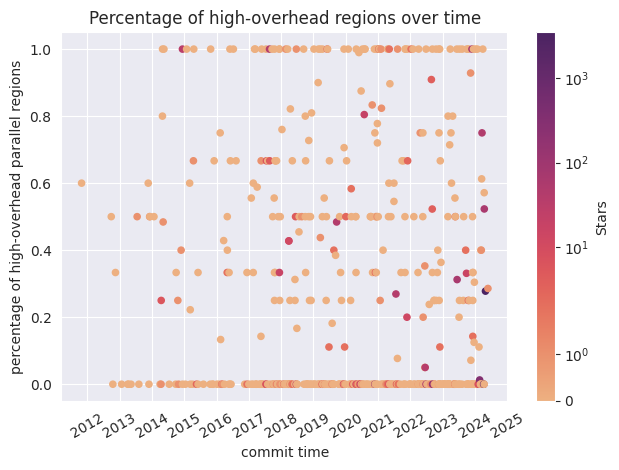

In [57]:
from matplotlib.dates import YearLocator, DateFormatter

fig, ax = plt.subplots()

if not df_overhead_rating.index.name == "Code":
    df_overhead_rating.set_index("Code")


data = df_repo_metadata.join(df_overhead_rating, on="Code")
data = data.drop("PushDate",axis=1).join(push_date_df,on="Code")


time_data = data[["PushDate","percentage","Stars"]].dropna()
time_data["PushDate"] = pd.to_datetime(time_data["PushDate"])

scatter= time_data.sort_values("PushDate").plot.scatter("PushDate","percentage", c="Stars",norm="symlog",cmap="flare",ax=ax)
#ax.set_yscale("log")
plt.xticks(rotation=30)
ax.set_ylabel("percentage of high-overhead parallel regions")
ax.set_xlabel("commit time")
# bar coloring according to percentages of loops
ax.set_title("Percentage of high-overhead regions over time")
#ax.legend()
ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))


plt.tight_layout()
plt.savefig(os.path.join(plot_path, "date_overhead_with_stars.pdf"))
plt.show()